In [1]:
import astropy.units as u
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.wcs import WCS
import scipy.ndimage as ndimage
import naima
from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table
import healpy as hp

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import SymLogNorm

from ClusterModel import model
from ClusterTools import map_tools
from ClusterTools import cluster_profile
from ClusterTools import cluster_spectra
from ClusterTools import cluster_global
from ClusterTools import cluster_xspec

In [2]:
dat_dir = os.getenv('CTAPHYS_EDAT_DIR')

pspc_data_file = dat_dir+'/ROSAT/RASS_1_2048.fits'
pspc_sp_file = dat_dir+'/ROSAT/spectrum.sp'
pspc_resp_file = dat_dir+'/ROSAT/pspcb_gain1_256.rsp'
lab_file = dat_dir+'/ROSAT/HI_LAB_II_1_256_nh.fits'
Xband = [0.1*u.keV, 2.4*u.keV]

reso_out = 1.0/60          # Pixel size in deg
FoV_out  = 3.0             # Size of the field of view

# Development of X-ray observables

In [3]:
cluster = model.Cluster(silent=False)

cluster.output_dir = '/Users/adam/Desktop/test'
cluster.coord = SkyCoord("194.95d  27.94d", frame="icrs", unit="deg")
cluster.map_coord = cluster.coord
cluster.map_fov = FoV_out*u.deg
cluster.map_reso = reso_out*u.deg
cluster.R500 = 1.31*u.Mpc           # Planck paper
cluster.R_truncation = 3*cluster.R500
cluster.redshift = 0.023
cluster.hse_bias = 0.0
# From Xi et al. (2018):
cluster.density_gas_model = {'name':'beta', 'beta':2.0/3, 'r_c':290*u.kpc, 'n_0':3e-3*u.cm**-3}
# From Planck PIPX (2013):
cluster.pressure_gas_model = {'name':'GNFW', 'P_0':2.2e-2*u.keV/u.cm**3,'a':1.8,'b':3.1,'c':0.0,'c500':2.9}

xmap, header = map_tools.roi_extract_healpix(pspc_data_file,
                                             cluster.coord.ra.to_value('deg'), cluster.coord.dec.to_value('deg'), 
                                             cluster.map_reso.to_value('deg'), 
                                             [cluster.map_fov[0].to_value('deg'), cluster.map_fov[1].to_value('deg')], 
                                             visu=False)
cluster.map_header = header

                 ______ _____ _____ ______ _____                 
                 | ___ \  ___|  __ \| ___ \  ___|                
                 | |_/ / |__ | |  \/| |_/ / |__                  
                 |  __/|  __|| | __ |    /|  __|                 
                 | |   | |___| |_\ \| |\ \| |___                 
                 \_|   \____/ \____/\_| \_\____/                 
                                                                 
  Pipeline for the Estimation of Gamma Ray Emission in clusters  
-----------------------------------------------------------------
                                                                 
Setting output_dir value
Setting coord value
Getting the coordinates
Setting the map coordinates
Setting: map_header to None, as map properties are now set by hand
Setting the map field of view
Setting: map_header to None, as map properties are now set by hand
Setting the map resolution value
Setting: map_header to None, as map properties

In [4]:
cluster.make_xspec_table(Emin=Xband[0], Emax=Xband[1],
                         Tmin=0.1*u.keV, Tmax=30.0*u.keV, nbin=100,
                         file_HI=lab_file, visu_nH=False,
                         model='APEC',
                         resp_file=pspc_resp_file, data_file=pspc_sp_file, app_nH_model=False,
                         Kcor=False)
r, T = cluster.get_temperature_gas_profile()
C,S,R = cluster.itpl_xspec_table(cluster.output_dir+'/XSPEC_table.txt', T)
C,S,R

<type 'float'>


/Users/adam/Project/anaconda3/envs/cta/lib/python2.7/site-packages/numpy/core/fromnumeric.py:734: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


ValueError: No XSPEC output found in /Users/adam/Desktop/test/xspec_analysis_output.txt

Getting D_ang value


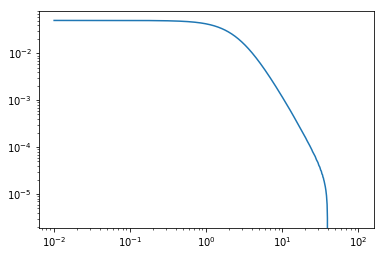

In [5]:
r, sx = cluster.get_sx_profile(output_type='R')
plt.loglog(r/cluster.D_ang, sx.to_value('s-1 arcmin-2'))

Getting R500 value
Getting R_truncation value
(array([283.6648219]), array([359.73733451]))


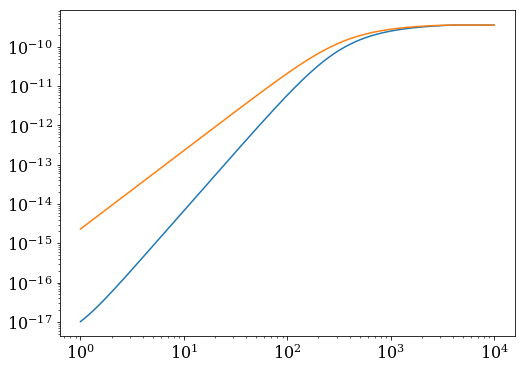

In [8]:
t = 'S'
r, fsph = cluster.get_fxsph_profile(output_type=t)
r, fcyl = cluster.get_fxcyl_profile(output_type=t)
plt.loglog(r,fsph)
plt.loglog(r,fcyl)

bid, f500 = cluster.get_fxsph_profile(cluster.R500)
bid, ftrunc = cluster.get_fxsph_profile(cluster.R_truncation)
print(f500.to_value('erg s-1 cm-2')*1e12, ftrunc.to_value('erg s-1 cm-2')*1e12)

In [9]:
# Get the model ymaps
FWHM = 5*u.arcmin
h = cluster.get_map_header()
m = cluster.get_sxmap(FWHM=FWHM, NR500max=5.0, Npt_los=100, output_type='R')

FWHM2sigma = 1.0/(2.0*np.sqrt(2*np.log(2)))
xmap_s = ndimage.gaussian_filter(xmap, sigma=FWHM2sigma*np.sqrt(FWHM.to_value('deg')**2-(1.8/60)**2)/reso_out, order=0)

Getting the coordinates
Getting the coordinates
Getting the coordinates
Getting the coordinates
Getting the coordinates
Getting the coordinates
Getting the coordinates
Getting the coordinates
Getting the coordinates


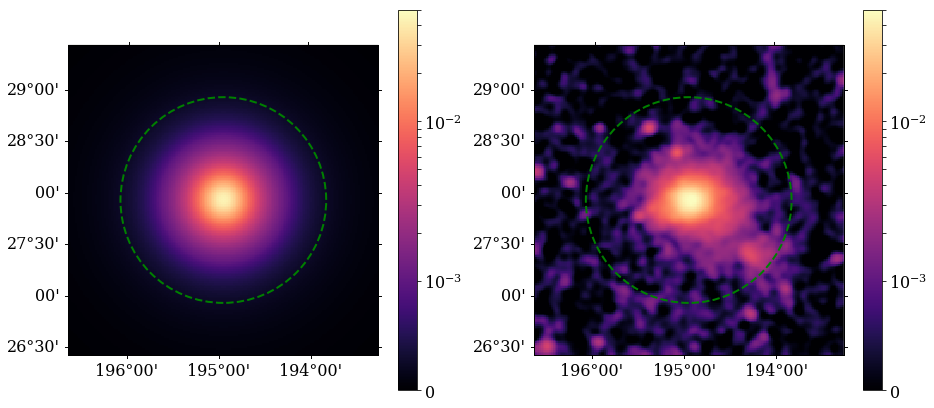

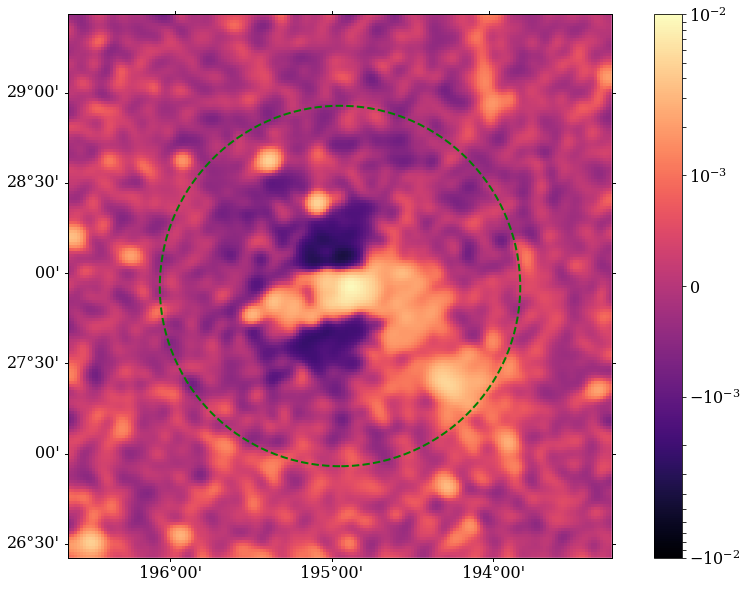

In [10]:
rad_show = 1.0
coeff = 5.24559/(hp.nside2resol(2048, arcmin=True)**2)
bkg = np.median(xmap*coeff - m.to_value('s-1 arcmin-2'))

fig = plt.figure(1, figsize=(15, 7))

# Model 1
ax1 = plt.subplot(121, projection=WCS(h))
plt.imshow(m.to_value('s-1 arcmin-2'), vmin=0, origin='lower', cmap='magma', norm=SymLogNorm(1e-3, vmin=0, vmax=5e-2))
circle_500 = matplotlib.patches.Ellipse((cluster.coord.ra.value, cluster.coord.dec.value),
                                        2*rad_show/np.cos(cluster.coord.dec.value*np.pi/180), 2*rad_show,
                                        linewidth=2, fill=False, zorder=2,
                                        edgecolor='green', linestyle='dashed',facecolor='none',
                                        transform=ax1.get_transform('fk5'))
ax1.add_patch(circle_500)
plt.colorbar()


# Data
ax2 = plt.subplot(122, projection=WCS(h))
plt.imshow(xmap_s*coeff-bkg, vmin=0, origin='lower', cmap='magma', norm=SymLogNorm(1e-3, vmin=0, vmax=5e-2))
circle_500 = matplotlib.patches.Ellipse((cluster.coord.ra.value, cluster.coord.dec.value),
                                        2*rad_show/np.cos(cluster.coord.dec.value*np.pi/180), 2*rad_show,
                                        linewidth=2, fill=False, zorder=2,
                                        edgecolor='green', linestyle='dashed',facecolor='none',
                                        transform=ax2.get_transform('fk5'))
ax2.add_patch(circle_500)
plt.colorbar()

# Data - model scaled
fig = plt.figure(2, figsize=(10, 7))
ax = plt.subplot(111, projection=WCS(h))
plt.imshow(xmap_s*coeff-bkg - m.to_value('s-1 arcmin-2'), cmap='magma', norm=SymLogNorm(1e-3, vmin=-1e-2, vmax=1e-2))
circle_500 = matplotlib.patches.Ellipse((cluster.coord.ra.value, cluster.coord.dec.value),
                                        2*rad_show/np.cos(cluster.coord.dec.value*np.pi/180), 2*rad_show,
                                        linewidth=2, fill=False, zorder=2,
                                        edgecolor='green', linestyle='dashed',facecolor='none',
                                        transform=ax.get_transform('fk5'))
ax.add_patch(circle_500)
plt.colorbar()

# Test impact of metalicity

True


/Users/adam/Project/anaconda3/envs/cta/lib/python2.7/site-packages/naima/radiative.py:1564: UserWarning: LUT PionDecayKafexhiu14_LUT_Pythia8.npz not found, reverting to useLUT = False
  LUT_fname


False


Text(0.5,0,'energy (GeV)')

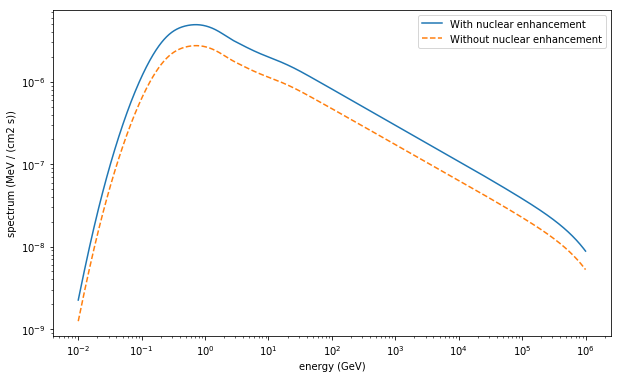

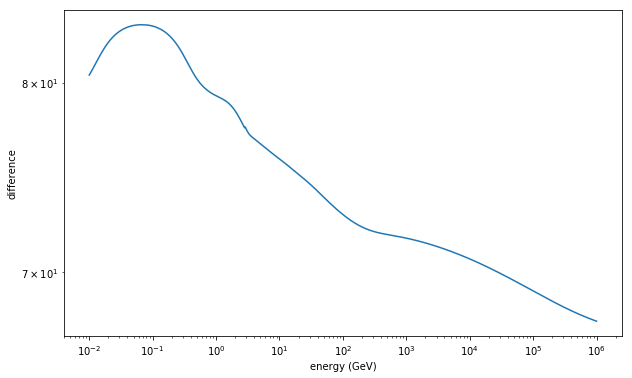

In [5]:
cluster = model.Cluster(silent=True)

cluster.nuclear_enhancement = True
e1, s1 = cluster.get_gamma_spectrum()
print(cluster._nuclear_enhancement)

cluster.nuclear_enhancement = False
e2, s2 = cluster.get_gamma_spectrum()
print(cluster._nuclear_enhancement)


spec1 = (e1**2*s1).to('MeV cm-2 s-1')
spec2 = (e2**2*s2).to('MeV cm-2 s-1')

fig = plt.figure(figsize=(10,6))
plt.loglog(e1, spec1, label='With nuclear enhancement')
plt.loglog(e2, spec2, '--', label='Without nuclear enhancement')
plt.ylabel('spectrum ('+str(spec1.unit)+')')
plt.xlabel('energy (GeV)')
plt.legend()

fig = plt.figure(figsize=(10,6))
plt.loglog(e1, (spec1-spec2)/spec2*100)
plt.ylabel('difference')
plt.xlabel('energy (GeV)')

# Test auto-plot tools

In [6]:
cluster = model.Cluster(silent=True)

In [7]:
cluster.output_dir = '/Users/adam/Desktop/test'
cluster.map_fov = 10*u.deg
cluster.plot(prod_list=['profile'])

!!! WARNING: XSPEC_table.txt not generated, skip Xray flux and Sx


# Test saving data

In [5]:
cluster = model.Cluster(silent=True)
cluster.output_dir = '/Users/adam/Desktop/test'

In [6]:
cluster.save_spectra()
cluster.save_profile()
cluster.save_map()

!!! WARNING: XSPEC_table.txt not generated, skip fx_sph
!!! WARNING: XSPEC_table.txt not generated, skip fx_cyl
!!! WARNING: XSPEC_table.txt not generated, skip sx
!!! WARNING: XSPEC_table.txt not generated, skip sx_map


In [7]:
new_table = Table.read(cluster.output_dir+'/SPECTRA.fits')

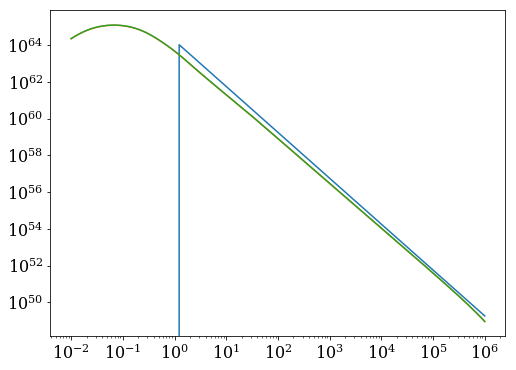

In [8]:
plt.loglog(new_table['Energy'], new_table['Spec_CRp'])
plt.loglog(new_table['Energy'], new_table['Spec_gamma_sph']*1e75)
plt.loglog(new_table['Energy'], new_table['Spec_gamma_cyl']*1e75)

# Test header from external data

In [3]:
cluster = model.Cluster(silent=True)

hdul = fits.open('/Users/adam/Project/NIKA/Data/External_data/TaurusMainFilament/taurusN3-070.fits')
header = hdul[0].header
cluster.map_header = header
cluster.coord = SkyCoord("04h25m23.0s +27d03m18s", frame="icrs", unit="deg") # Perseus
cluster.save_map()

!!! WARNING: XSPEC_table.txt not generated, skip sx_map


# Test saving/loading parameters

In [ ]:
cluster.M500 = 1.1431e14*u.Msun
cluster.save_param()

In [ ]:
cluster2 = model.Cluster()
cluster2.load_param(cluster.output_dir+'/parameters.pkl')
cluster2.print_param()

In [ ]:
cluster.print_param()

# Test Gamma ray computation

In [ ]:
cluster = model.Cluster(silent=True)
cluster.redshift = 0.012
cluster.map_fov = 10*u.deg
cluster.map_reso = 0.01*u.deg

In [ ]:
m = cluster.get_gamma_template_map(NR500max=5.0, Npt_los=100)
header = cluster.get_map_header()

(map_tools.get_map_norm(m.to_value('sr-1'), header)-1)/100.0

In [ ]:
rad_show = cluster.theta_truncation.to_value('deg')
plt.figure(0, figsize=(15,15))
ax = plt.subplot(111, projection=WCS(header))
plt.imshow(m.to_value('sr-1'), vmin=0,origin='lower', cmap='magma', norm=SymLogNorm(1))
circle_500 = matplotlib.patches.Ellipse((cluster.coord.ra.value, cluster.coord.dec.value),
                                        2*rad_show/np.cos(cluster.coord.dec.value*np.pi/180), 2*rad_show,
                                        linewidth=2, fill=False, zorder=2,
                                        edgecolor='green', linestyle='dashed',facecolor='none',
                                        transform=ax.get_transform('fk5'))
ax.add_patch(circle_500)
plt.colorbar()

In [ ]:
r1, p1 = cluster.get_gamma_profile(radius=np.logspace(0,4,1000)*u.kpc, 
                                 Emin=500*u.GeV, Emax=1*u.PeV, Energy_density=False,
                                 NR500max=5.0, Npt_los=100)
r2, p2 = cluster.get_gamma_profile(radius=np.logspace(0,4,1000)*u.kpc, 
                                 Emin=1000*u.GeV, Emax=10*u.PeV, Energy_density=False,
                                 NR500max=3, Npt_los=100)
plt.figure(0,figsize=(15,10))
plt.loglog((r1/cluster.D_ang*u.rad).to('deg'),p1.to('cm-2 s-1 sr-1'), '-')
plt.loglog((r2/cluster.D_ang*u.rad).to('deg'),p2.to('cm-2 s-1 sr-1'), '--')
plt.ylim(1e-15, 1e-7)

In [ ]:
eng    = np.logspace(-3, 6, 100)*u.GeV
eng1, dN_dEdSdt1 = cluster.get_gamma_spectrum(eng, Rmax=1000*u.kpc, type_integral='spherical')
eng2, dN_dEdSdt2 = cluster.get_gamma_spectrum(eng, Rmax=1000*u.kpc, type_integral='cylindrical')

plt.figure(1,figsize=(15,10))
plt.loglog(eng1, dN_dEdSdt1, '')
plt.loglog(eng2, dN_dEdSdt2, '--')

In [ ]:
cluster.X_cr = {'X':1e-2, 'Rcut':1000*u.kpc}

Rmax = 100*u.kpc
Nptrad = 100
eng    = np.logspace(-2, 4, 100)*u.GeV

# Method 1: parsing Naima somehow
radius1 = np.logspace(0, 4, 1000)*u.kpc
bid, nh_r  = cluster.get_density_gas_profile(radius1)
bid, ncr_r = cluster.get_normed_density_crp_profile(radius1)

V_cross = cluster_profile.get_volume_any_model(radius1.to_value('kpc'), nh_r.to_value('cm-3')*ncr_r, Rmax.to_value('kpc')) * u.kpc**3
V_auto  = cluster_profile.get_volume_any_model(radius1.to_value('kpc'), ncr_r, cluster.X_cr['Rcut'].to_value('kpc')) * u.kpc**3

CRp1 = naima.models.PowerLaw(1.0/u.GeV, 1.0*u.GeV, cluster.spectrum_crp_model['Index'])
g1 = naima.models.PionDecay(CRp1, nh=1.0*u.Unit('cm**-3'))
Unorm = cluster.X_cr['X']*cluster.get_thermal_energy_profile(cluster.X_cr['Rcut'])[1][0]
g1.set_Wp(Unorm, Epmin=cluster.Epmin, Epmax=cluster.Epmax)
dN_dEdSdt1 = (V_cross/V_auto).to_value('') * g1.flux(eng, distance=cluster.D_lum).to('MeV-1 cm-2 s-1')

# Method 3: parsing Naima with a hand defined normalization
eng3, dN_dEdSdt3 = cluster.get_gamma_spectrum(eng, Rmax=Rmax, type_integral='spherical')
    
# Method 2: direct shell integration
radius2 = np.logspace(0, np.log10(Rmax.to_value('kpc')), Nptrad)*u.kpc
bid, nh_r  = cluster.get_density_gas_profile(radius2)
bid, X_r   = cluster.get_crp_to_thermal_energy_profile(radius2)
bid, Uth_r = cluster.get_thermal_energy_profile(radius2)

CRp2 = naima.models.PowerLaw(1.0/u.GeV, 1.0*u.GeV, cluster.spectrum_crp_model['Index'])

for i in range(Nptrad):
    if i>0 : 
        UCR_shell = X_r[i].to_value('adu')*Uth_r[i] - X_r[i-1].to_value('adu')*Uth_r[i-1]
    else:
        UCR_shell = X_r[i].to_value('adu')*Uth_r[i]
    g2 = naima.models.PionDecay(CRp2, nh=nh_r[i])
    g2.set_Wp(UCR_shell,Epmin=cluster.Epmin, Epmax=cluster.Epmax)
    if i==0 : dN_dEdSdt2 = g2.flux(eng, distance=cluster.D_lum).to('MeV-1 cm-2 s-1')
    else : dN_dEdSdt2 += g2.flux(eng, distance=cluster.D_lum).to('MeV-1 cm-2 s-1')

In [ ]:
# Plots
plt.figure(1,figsize=(15,10))
plt.loglog(eng.to('GeV'), (eng**2*dN_dEdSdt1).to('GeV cm-2 s-1'), 'r')
plt.loglog(eng.to('GeV'), (eng**2*dN_dEdSdt2).to('GeV cm-2 s-1'), 'g--')
plt.loglog(eng.to('GeV'), (eng**2*dN_dEdSdt3).to('GeV cm-2 s-1'), 'b--')

plt.figure(2,figsize=(15,10))
plt.plot(eng.to('GeV'), 100*((eng**2*dN_dEdSdt3).to('GeV cm-2 s-1') - (eng**2*dN_dEdSdt2).to('GeV cm-2 s-1'))/(eng**2*dN_dEdSdt3).to('GeV cm-2 s-1') , 'r')
plt.yscale('log')
plt.ylim(1e-2,1e1)

In [ ]:
# check that calculating the flux from spectrum and then profile is similar as the other way around
Emin = 10*u.MeV
Emax = 1*u.PeV
Rmax = cluster.R500

# Get the spectrum and integrate
energy=np.logspace(np.log10(Emin.to_value('GeV')),np.log10(Emax.to_value('GeV')),1000)*u.GeV
energy, dN_dEdSdt = cluster.get_gamma_spectrum(energy, Rmax=Rmax, type_integral='cylindrical', NR500max=5, Npt_los=100)
flux1 = cluster_spectra.get_integral_any_model(energy.to_value('GeV'),
                                               dN_dEdSdt.to_value('GeV-1 cm-2 s-1'),#*energy.to_value('GeV'),
                                               Emin.to_value('GeV'), Emax.to_value('GeV')) * u.Unit('cm-2 s-1')

# Get the profile and integrate
r3d = cluster_profile.define_safe_radius_array(np.array([Rmax.to_value('kpc')]), Rmin=1.0)*u.kpc
r2d, dN_dSdtdO  = cluster.get_gamma_profile(r3d, Emin=Emin, Emax=Emax, Energy_density=False, NR500max=5, Npt_los=100)

integrand = dN_dSdtdO.to_value('cm-2 s-1 sr-1') / cluster.D_ang.to_value('kpc')**2
flux2 = cluster_profile.get_surface_any_model(r2d.to_value('kpc'), integrand, Rmax.to_value('kpc'), Npt=1000)*u.cm**-2*u.s**-1#*u.GeV
            
    
flux3 = cluster.get_gamma_flux(Rmax=Rmax, type_integral='cylindrical', NR500max=5.0, Npt_los=100,
                       Emin=Emin, Emax=Emax, Energy_density=False)
    
flux1,flux2,flux3, (flux2-flux1)/flux2

# Test CRp model

In [ ]:
cluster = model.Cluster()
cluster2 = model.Cluster()

In [ ]:
cluster.X_cr = {'X':1e-2, 'Rcut':cluster.R500*5}
cluster.X_cr = {'X':1e-2, 'Rcut':cluster.R_truncation}
cluster2.X_cr = {'X':5e-2, 'Rcut':cluster.R500}

#cluster.density_crp_model = {'name':'GNFW', 'a':cluster.pressure_gas_model['a'], 
#                             'b':cluster.pressure_gas_model['b'], 'c':cluster.pressure_gas_model['c'], 
#                             'r_p':cluster.pressure_gas_model['r_p']}
r, x = cluster.get_crp_to_thermal_energy_profile()
r2, x2 = cluster2.get_crp_to_thermal_energy_profile()
plt.loglog(r,x)
plt.loglog(r2,x2)
plt.hlines(cluster.X_cr['X'], 1,1e4)
plt.vlines(cluster.X_cr['Rcut'].to_value('kpc'), cluster.X_cr['X']/2,cluster.X_cr['X']*2)
plt.hlines(cluster2.X_cr['X'], 1,1e4)
plt.vlines(cluster2.X_cr['Rcut'].to_value('kpc'), cluster2.X_cr['X']/2,cluster2.X_cr['X']*2)

In [ ]:
cluster.spectrum_crp_model = {'name':'PowerLaw', 'Index':1.0}
r1, n1 = cluster.get_density_crp_profile(Emin=0.1*u.TeV, Emax=10*u.PeV)
cluster.spectrum_crp_model = {'name':'PowerLaw', 'Index':1.0}
r2, n2 = cluster.get_density_crp_profile(Emin=0.1*u.TeV, Emax=100*u.PeV)
plt.loglog(r1, n1)
plt.loglog(r2, n2)

In [ ]:
cluster.spectrum_crp_model = {'name':'PowerLaw', 'Index':2.0}
e1, s1 = cluster.get_crp_spectrum(Rmax=100*u.kpc)
cluster.spectrum_crp_model = {'name':'PowerLaw', 'Index':3.0}
e2, s2 = cluster.get_crp_spectrum(Rmax=100*u.kpc)
cluster.spectrum_crp_model = {'name':'PowerLaw', 'Index':2.0}

cluster.X_cr = {'X':cluster.X_cr['X'], 'Rcut':0.1*cluster.R500}
e3, s3 = cluster.get_crp_spectrum(Rmax=100*u.kpc)

plt.loglog(e1,s1)
plt.loglog(e2,s2)
plt.loglog(e3,s3)

In [ ]:
cluster.density_crp_model

In [ ]:
cluster.density_crp_model = {'name':'GNFW', 'a':1, 'b':1, 'c':1, 'r_p':100*u.kpc}
cluster.density_crp_model = {'name':'beta', 'beta':1, 'r_c':1*u.kpc}
cluster.density_crp_model = {'name':'doublebeta', 'beta1':1, 'beta2':1, 'r_c1':1*u.kpc, 'r_c2':1*u.kpc, 'n_01':1.0, 'n_02':1.0}
cluster.density_crp_model = {'name':'SVM', 'beta':1, 'alpha':1, 'gamma':1, 'epsilon':1, 'r_c':1*u.kpc, 'r_s':1.0*u.kpc}

In [ ]:
cluster.density_crp_model

In [ ]:
cluster.spectrum_crp_model = {'name':'PowerLaw', 'Index':1.0}
cluster.spectrum_crp_model = {'name':'ExponentialCutoffPowerLaw', 'Index':1.0, 'CutoffEnergy':1e3*u.TeV}

In [ ]:
cluster.spectrum_crp_model

In [ ]:
cluster.density_crp_model = {'name':'GNFW', 'a':1.0, 'b': 5.0, 'c':0.3, 'r_p':400*u.kpc}

r, fr = cluster.get_normed_density_crp_profile()
plt.loglog(r, fr)

In [ ]:
#cluster.spectrum_crp_model = {'name':'PowerLaw', 'Index':2.5}
cluster.spectrum_crp_model = {'name':'ExponentialCutoffPowerLaw', 'Index':2.5, 'CutoffEnergy':5.0*u.PeV}
cluster.Epmax = 10*u.PeV
e, fe = cluster.get_normed_crp_spectrum(np.logspace(-1,7,1000)*u.GeV)
plt.loglog(e, fe)

In [ ]:
r, uth = cluster.get_thermal_energy_profile()
rl, uthl = cluster.get_thermal_energy_profile(cluster.R500)

plt.figure(figsize=(15,10))
plt.loglog(r, uth.to('erg'))
plt.loglog(rl, uthl.to('erg'), 'o')
uthl.to('erg')

# Test pressure, density, temperature profiles

In [ ]:
cluster = model.Cluster()

In [ ]:
# pressure profile
cluster = model.Cluster()
#cluster.R_truncation = np.inf*u.kpc
r1, p_r1 = cluster.get_pressure_gas_profile()
cluster.set_pressure_gas_gNFW_param('A10UPP')
r2, p_r2 = cluster.get_pressure_gas_profile()
cluster.set_pressure_gas_gNFW_param('A10MD')
r3, p_r3 = cluster.get_pressure_gas_profile()
cluster.set_pressure_gas_gNFW_param('A10CC')
r4, p_r4 = cluster.get_pressure_gas_profile()
cluster.set_pressure_gas_gNFW_param('P13UPP')
r5, p_r5 = cluster.get_pressure_gas_profile()

cluster.theta500 = 0.1*u.deg
print(cluster.R500, cluster.M500)
cluster.set_pressure_gas_gNFW_param('P13UPP')
r6, p_r6 = cluster.get_pressure_gas_profile()

cluster.R_truncation = np.inf*u.kpc
r7, p_r7 = cluster.get_pressure_gas_profile()

cluster.pressure_gas_model = {'name':'GNFW', 'P_0':1*u.Unit('keV cm-3'), 'a':2.0,'b':5.0,'c':0.0, 'r_p':500.0*u.kpc}
r8, p_r8 = cluster.get_pressure_gas_profile()

cluster.pressure_gas_model = {'name':'isoT', 'T':10*u.keV}
r9, p_r9 = cluster.get_pressure_gas_profile()

In [ ]:
plt.figure(figsize=(15,10))
plt.loglog(r1, p_r1, '-.', linewidth=4, label='Default')
plt.loglog(r2, p_r2, label='A10UPP')
plt.loglog(r3, p_r3, label='A10MD')
plt.loglog(r4, p_r4, label='A10CC')
plt.loglog(r5, p_r5, label='P13UPP')
plt.loglog(r6, p_r6, label='P13UPP new mass')
plt.loglog(r7, p_r7, '-.', linewidth=4, label='P13UPP new mass, no truncation')
plt.loglog(r8, p_r8, '-.', linewidth=4, label='Stupid model')
plt.loglog(r9, p_r9, '--', linewidth=4, label='isoT')
plt.hlines(1,0,1e4)
plt.legend()

In [ ]:
cluster.density_gas_model = {'name':'doublebeta', 
                             'n_01':1e-2*u.Unit('cm-3'), 'beta1':2.0, 'r_c1':500.0*u.kpc,
                             'n_02':1e-2*u.Unit('cm-3'), 'beta2':2.0, 'r_c2':500.0*u.kpc}
print(cluster.density_gas_model)

cluster.density_gas_model = {'name':'SVM', 
                            'n_0':1.0*u.cm**-3,'beta':1,'r_c':100*u.kpc,'r_s':1*u.kpc, 
                             'alpha':1, 'gamma':1, 'epsilon':1}
print(cluster.density_gas_model)

In [ ]:
cluster.R_truncation = 2500*u.kpc

cluster.density_gas_model = {'name':'doublebeta', 
                             'n_01':1e-2*u.Unit('cm-3'), 'beta1':2.0, 'r_c1':100.0*u.kpc,
                             'n_02':1e-3*u.Unit('cm-3'), 'beta2':0.5, 'r_c2':500.0*u.kpc}
r1, n_r1 = cluster.get_density_gas_profile()

cluster.density_gas_model = {'name':'beta', 
                             'n_0':1e-3*u.Unit('cm-3'), 'beta':0.5, 'r_c':500.0*u.kpc}
r2, n_r2 = cluster.get_density_gas_profile()

cluster.density_gas_model = {'name':'SVM', 
                            'n_0':1e-3*u.cm**-3,'beta':0.5,'r_c':500*u.kpc,'r_s':5000*u.kpc, 
                             'alpha':0.3, 'gamma':3, 'epsilon':15.0}
r3, n_r3 = cluster.get_density_gas_profile()

In [ ]:
plt.figure(figsize=(15,10))
plt.loglog(r1, n_r1, '-.', linewidth=3, label='doublebeta')
plt.loglog(r2, n_r2, label='beta')
plt.loglog(r3, n_r3, label='svm')
plt.legend()

In [ ]:
cluster.set_pressure_gas_gNFW_param('P13UPP')

r1, T_r1 = cluster.get_temperature_gas_profile()
cluster.density_gas_model = {'name':'doublebeta', 
                             'n_01':1e-1*u.Unit('cm-3'), 'beta1':1.5, 'r_c1':50.0*u.kpc,
                             'n_02':1e-3*u.Unit('cm-3'), 'beta2':0.5, 'r_c2':500.0*u.kpc}
cluster.set_pressure_gas_gNFW_param('A10MD')
r2, T_r2 = cluster.get_temperature_gas_profile()

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(r1, T_r1)
plt.plot(r2, T_r2)
plt.xscale('log')

# Derived mass and integrated quantities

In [ ]:
cluster = model.Cluster()
cluster.R_truncation = 5000.0*u.kpc#np.inf*u.kpc
print(cluster.R500)
print(cluster.M500)

In [ ]:
cluster.set_pressure_gas_gNFW_param('A10CC')
cluster.density_gas_model = {'name':'SVM', 
                             'n_0':3e-2*u.cm**-3,'beta':0.0,'r_c':50.0*u.kpc,'r_s':500.0*u.kpc, 
                             'alpha':0.8, 'gamma':1.0, 'epsilon':6.0}

In [ ]:
r,p = cluster.get_pressure_gas_profile()
r,n = cluster.get_density_gas_profile()
plt.loglog(r, n, label='n')
plt.loglog(r,p, label='p')
plt.legend()

In [ ]:
r, mhse = cluster.get_hse_mass_profile()

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(r, mhse)
plt.xscale('log')
plt.yscale('log')

In [ ]:
cluster.R_truncation = 2000.0*u.kpc#np.inf*u.kpc

r, delta = cluster.get_overdensity_contrast_profile()
r1, delta1 = cluster.get_overdensity_contrast_profile(5*u.kpc)
r2, delta2 = cluster.get_overdensity_contrast_profile(500*u.kpc)
r2500_p, m2500_p = cluster.get_mdelta_from_profile(2500, 10*u.kpc, 1e5*u.kpc)
r500_p, m500_p = cluster.get_mdelta_from_profile(500, 10*u.kpc, 1e4*u.kpc)
r200_p, m200_p = cluster.get_mdelta_from_profile(200, 10*u.kpc, 1e5*u.kpc)
plt.loglog(r, delta)
plt.loglog(r1, delta1, 'o')
plt.loglog(r2, delta2, 'o')
plt.vlines(r2500_p.to_value('kpc'), 10, 1e8, color='g')
plt.vlines(r500_p.to_value('kpc'), 10, 1e8, color='r')
plt.vlines(r200_p.to_value('kpc'), 10, 1e8)
plt.hlines(2500, 1e0, 1e4, color='g')
plt.hlines(500, 1e0, 1e4, color='r')
plt.hlines(200, 1e0, 1e4)
print(m200_p)

In [ ]:
r, mgas = cluster.get_gas_mass_profile()
r1, mgas1 = cluster.get_gas_mass_profile([1,2,3,4]*u.kpc)
plt.loglog(r, mgas)
plt.loglog(r1, mgas1, 'o')
plt.xlim(0.5,10)
plt.ylim(1e8,1e11)

In [ ]:
r, fgas = cluster.get_fgas_profile()
plt.plot(r, fgas)
plt.xscale('log')

In [ ]:
r,n = cluster.get_density_gas_profile(100.0*u.kpc)
print(r, n)

# Compton parameter

In [ ]:
plt.figure(figsize=(15,10))
rsph, ysph = cluster.get_ysph_profile()
rcyl, ycyl = cluster.get_ycyl_profile()
plt.loglog(rsph, ysph)
plt.loglog(rcyl, ycyl)

In [ ]:
plt.plot(rcyl, ycyl/ysph)
plt.xscale('log')
plt.yscale('log')
plt.ylim(0.1,50)
plt.hlines(1,0,1e5)

In [ ]:
print(cluster.R500)
cluster.R_truncation = np.inf*u.kpc
Rp, y = cluster.get_y_compton_profile(np.logspace(0,np.log10(8*cluster.R500.to_value('kpc')),1000)*u.kpc)
Rp3, y3 = cluster.get_y_compton_profile(np.logspace(0,np.log10(8*cluster.R500.to_value('kpc')),1000)*u.kpc,NR500max=2)
Rp1, y1 = cluster.get_y_compton_profile(np.logspace(0,2, 100)*u.kpc)
Rp2, y2 = cluster.get_y_compton_profile([3,10,135,2000]*u.kpc)
plt.figure(figsize=(13,10))
plt.plot(Rp, y, label='Ref')
plt.plot(Rp1, y1, '.', markersize=15)
plt.plot(Rp2, y2, '.', markersize=15)
plt.plot(Rp3, y3, '--', markersize=15)
plt.xscale('log')
plt.yscale('log')
plt.legend()

In [ ]:
r, m = cluster.get_gas_mass_profile()
r2, m2 = cluster.get_gas_mass_profile(600*u.kpc)

In [ ]:
plt.figure(figsize=(15,10))
plt.loglog(r, m)
plt.loglog(r2, m2, 'o')

In [ ]:
r, m = cluster.get_fgas_profile()
r2,m2 = cluster.get_fgas_profile(600*u.kpc)
r3,m3 = cluster.get_fgas_profile(1200*u.kpc)

In [ ]:
plt.figure(figsize=(15,10))
plt.loglog(r, m)
plt.loglog(r2, m2, 'o')
plt.loglog(r3, m3, 'o')

# Maps

In [ ]:
# Extract a map as template

reso_out = 1.0/60          # Pixel size in deg
FoV_out  = 6.0             # Size of the field of view
coord1    = SkyCoord("03h19m47.2s +41d30m47s", frame="icrs", unit="deg") # Perseus
coord2    = SkyCoord("194.953d  27.9806d", frame="icrs", unit="deg") # Coma

dat_dir = os.getenv('CTAPHYS_EDAT_DIR')
ymap_file  = dat_dir+'/Planck/COM_CompMap_Compton-SZMap-milca-ymaps_2048_R2.00.fits'
ymap1, header1 = map_tools.roi_extract_healpix(ymap_file, coord1.ra.value, coord1.dec.value, 
                                   reso_out, [FoV_out, FoV_out], visu=False)
ymap2, header2 = map_tools.roi_extract_healpix(ymap_file, coord2.ra.value, coord2.dec.value, 
                                   reso_out, [FoV_out, FoV_out], visu=False)
FWHM2sigma = 1.0/(2.0*np.sqrt(2*np.log(2)))
sm = 5.0
ymap1 = ndimage.gaussian_filter(ymap1, sigma=(FWHM2sigma*sm/60/reso_out, FWHM2sigma*sm/60/reso_out), order=0)
ymap2 = ndimage.gaussian_filter(ymap2, sigma=(FWHM2sigma*sm/60/reso_out, FWHM2sigma*sm/60/reso_out), order=0)

In [ ]:
# Model Perseus
cluster1 = model.Cluster()
cluster1.R_truncation = np.inf*u.kpc
cluster1.M500 = 7e14*u.Msun
cluster1.redshift = 0.0179
cluster1.coord = {'RA':coord1.ra, 'Dec':coord1.dec}
cluster1.set_pressure_gas_gNFW_param('P13UPP')

#cluster1.map_coord = coord1
#cluster1.map_reso = reso_out*u.deg
#cluster1.map_fov = [FoV_out, FoV_out]*u.deg
cluster1.map_header = header1

# Model Coma
cluster2 = model.Cluster()
cluster2.R_truncation = np.inf*u.kpc
cluster2.M500 = 6e14*u.Msun
cluster2.redshift = 0.023
cluster2.coord = {'RA':coord2.ra, 'Dec':coord2.dec}
cluster2.set_pressure_gas_gNFW_param('P13UPP')

#cluster2.map_coord = coord2
#cluster2.map_reso = reso_out*u.deg
#cluster2.map_fov = [FoV_out, FoV_out]*u.deg
cluster2.map_header = header2

In [ ]:
# Get the model ymaps
h1 = cluster1.get_map_header()
y1 = cluster1.get_ymap(FWHM=np.sqrt(10.0**2+sm**2)*u.arcmin, NR500max=5.0, Npt_los=100)
h2 = cluster2.get_map_header()
y2 = cluster2.get_ymap(FWHM=np.sqrt(10.0**2+sm**2)*u.arcmin, NR500max=5.0, Npt_los=100)

In [ ]:
rad_show = 1.0

fig = plt.figure(1, figsize=(15, 25))

# Model 1
ax1 = plt.subplot(321, projection=WCS(h1))
plt.imshow(1e6*y1, vmin=-20, vmax=20, origin='lower', cmap='RdYlBu')
circle_500 = matplotlib.patches.Ellipse((cluster1.coord.ra.value, cluster1.coord.dec.value),
                                        2*rad_show/np.cos(cluster1.coord.dec.value*np.pi/180), 2*rad_show,
                                        linewidth=2, fill=False, zorder=2,
                                        edgecolor='green', linestyle='dashed',facecolor='none',
                                        transform=ax1.get_transform('fk5'))
ax1.add_patch(circle_500)
plt.colorbar()

# Model 2
ax2 = plt.subplot(322, projection=WCS(h2))
plt.imshow(1e6*y2, vmin=-20, vmax=20, origin='lower', cmap='RdYlBu')
circle_500 = matplotlib.patches.Ellipse((cluster2.coord.ra.value, cluster2.coord.dec.value),
                                        2*rad_show/np.cos(cluster2.coord.dec.value*np.pi/180), 2*rad_show,
                                        linewidth=2, fill=False, zorder=2,
                                        edgecolor='green', linestyle='dashed',facecolor='none',
                                        transform=ax2.get_transform('fk5'))
ax2.add_patch(circle_500)
plt.colorbar()

# Model 1 - Perseus
ax3 = plt.subplot(323, projection=WCS(h1))
plt.imshow(1e6*(ymap1-y1.to_value('adu')), vmin=-20, vmax=20, origin='lower', cmap='RdYlBu')
circle_500 = matplotlib.patches.Ellipse((cluster1.coord.ra.value, cluster1.coord.dec.value),
                                        2*rad_show/np.cos(cluster1.coord.dec.value*np.pi/180), 2*rad_show,
                                        linewidth=2, fill=False, zorder=2,
                                        edgecolor='green', linestyle='dashed',facecolor='none',
                                        transform=ax3.get_transform('fk5'))
ax3.add_patch(circle_500)
plt.colorbar()

# Model 2 - Coma
ax4 = plt.subplot(324, projection=WCS(h2))
plt.imshow(1e6*(ymap2-y2.to_value('adu')), vmin=-20, vmax=20, origin='lower', cmap='RdYlBu')
circle_500 = matplotlib.patches.Ellipse((cluster2.coord.ra.value, cluster2.coord.dec.value),
                                        2*rad_show/np.cos(cluster2.coord.dec.value*np.pi/180), 2*rad_show,
                                        linewidth=2, fill=False, zorder=2,
                                        edgecolor='green', linestyle='dashed',facecolor='none',
                                        transform=ax4.get_transform('fk5'))
ax4.add_patch(circle_500)
plt.colorbar()

# Perseus
ax5 = plt.subplot(325, projection=WCS(header1))
plt.imshow(1e6*ymap1, vmin=-20, vmax=20, origin='lower', cmap='RdYlBu')
circle_500 = matplotlib.patches.Ellipse((coord1.ra.value, coord1.dec.value),
                                        2*rad_show/np.cos(coord1.dec.value*np.pi/180), 2*rad_show,
                                        linewidth=2, fill=False, zorder=2,
                                        edgecolor='green', linestyle='dashed',facecolor='none',
                                        transform=ax1.get_transform('fk5'))
ax1.add_patch(circle_500)
plt.colorbar()

# Coma
ax6 = plt.subplot(326, projection=WCS(header2))
plt.imshow(1e6*ymap2, vmin=-20, vmax=20, origin='lower', cmap='RdYlBu')
circle_500 = matplotlib.patches.Ellipse((coord2.ra.value, coord2.dec.value),
                                        2*rad_show/np.cos(coord2.dec.value*np.pi/180),2*rad_show,
                                        linewidth=2, fill=False, zorder=2,
                                        edgecolor='green', linestyle='dashed',facecolor='none',
                                        transform=ax2.get_transform('fk5'))
ax2.add_patch(circle_500)
plt.colorbar()